The scope of this notebook is to perform an in-depth analysis of an image classification problem trying to detect people affected by pneumonia by looking at 5,852 jpg x-rays images. These datasets come from the website Mendeley which collected x-rays copies from patients affected by pneumonia in a number of pediatric hospitals in the South of China. The dataset presents a 75/15 % split respectively for pnemumonia affected and healthy people.

We'll perform several iterations of Neural Network (NN) modelling in order to improve on performance by going through the following process:


1) Data pre-processing for NN

2) Comparing performance across different types of NN

3) Hyperparameter tuning on each type

4) Increasing image quality of quantity if necessary


We'll then select a winning model and perform threshold selection on it based on potential social and economics costs related to pneumonia. Given the binary nature of this image classification issue, we'll be adopting **ROC score** as our main metric to measure good performance throughout the modelling. Other metrics such as F1 and Accuracy will also be added within the final evaluation of the winning model.

We have split up the project into two parts, the first will reshuffle the data into a newly subsetted group of training and validation splits as the original file received only contained 16 validation images compared with 5000+ training. The second part will use the original dataset structure. 

# Loading and pre-processing of images

In [3]:
# importing the relevant packages
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, MaxPooling2D, Dropout, DepthwiseConv2D, Activation
from keras import optimizers

from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, recall_score
from sklearn.metrics import  roc_curve, confusion_matrix, precision_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  roc_curve
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense

import os
from glob import glob

Using TensorFlow backend.


In [2]:
train_directory = 'data/train/'
test_directory = 'data/test/'
validation_directory = 'data/val'



Initially, we arbitrariliy decide to use only 1500 and 300 images respectivaly for training and validation. Also, initial image quality is arbitrarily set at 500 x 500. If necessary, we'll come back to this and increase the image resolution in case 500 x 500 is not enough for algorithms to detect meaningful patterns.

In [3]:
# gaussian blurring and grayscaling!!! and 64x64
# getting all the images in the directory training/normal and reshape them to 600 pixels
train_generator_base = ImageDataGenerator(rescale= 1./255).flow_from_directory(
        train_directory, 
        target_size=(500,500),
        batch_size = 1500,
        color_mode = 'grayscale',
        seed = 12
        )

validation_generator_base = ImageDataGenerator(rescale= 1./255).flow_from_directory(
        validation_directory, 
        target_size=(500,500),
        batch_size = 300,
        color_mode= 'grayscale',
        seed= 103
        )

test_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory(
        test_directory , 
        target_size=(500,500),
        batch_size = 600,
        color_mode = 'grayscale',
        seed=44
       )



Found 4201 images belonging to 2 classes.
Found 1028 images belonging to 2 classes.
Found 623 images belonging to 2 classes.


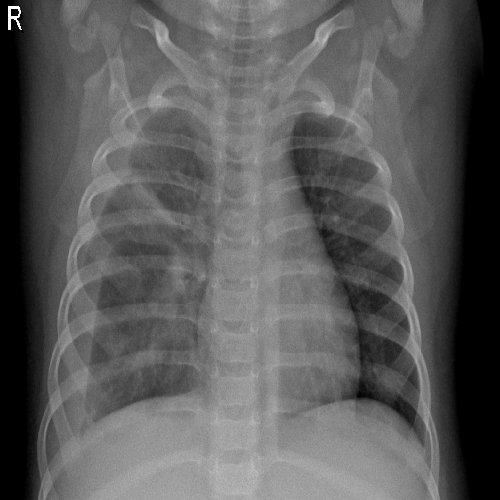

In [4]:
# create the datasets
train_images, train_labels = next(train_generator_base)
validation_images, validation_labels = next(validation_generator_base)
test_images, test_labels = next(test_generator)



array_to_img(train_images[0])

Above is one example of the images we'll be working on.

In [7]:
# looking at the dataset shapes of all our images

print('------------data')
print(train_images.shape)
print(validation_images.shape)
print(test_images.shape)


print('-----------target')
print(train_labels.shape)
print(validation_labels.shape)
print(test_labels.shape)


------------data
(1500, 500, 500, 1)
(300, 500, 500, 1)
(600, 500, 500, 1)
-----------target
(1500, 2)
(300, 2)
(600, 2)


In [42]:
# We need to transform our training and validation dataset into a (1500, 500x500x1) and (300, 500x500x1) respectively

train_img_dense = train_images.reshape(1500,-1)
validation_img_dense = validation_images.reshape(300, -1)



## Functions for visualisation and roc_score


In [4]:
# roc_score
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

# visualisations
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_auroc'])
    plt.plot(history['auroc'])
    plt.legend(['val_auroc', 'auroc'])
    plt.title('roc_auc')
    plt.xlabel('epochs')
    plt.ylabel('roc_auc')
    plt.show()

Due to the fact that roc_score cannot be calculated in mini-batches, we need to create a custom function that measures roc_score at the end of each epoch.
Also, implementing a visualisation function for loss, accuracy and roc_score.

## Baseline Model

As baseline model, we'll be using a simple Dense layer model. Dense layers are usually not the preferred choice when it comes to image recognition as they are not able to detect pattern in a 'geometric' way in the same way CNN do with horizontal and vertical lines. The input_size for a Dense NN is simply a vector long as the size of the image multiplied by the different layers. In our case, this would 500 width x 500 height x 1 layer (because we pre-processed the images to be in grayscale)

In [9]:
# checking for new shapes
print(train_img_dense.shape)
print(validation_img_dense.shape)


(1500, 250000)
(300, 250000)


In [10]:
# double-checking what tuple corresponds to each class 

print(train_generator_base.class_indices)
print(validation_generator_base.class_indices)
print(test_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [11]:
# reshaping the train and test labels with 1 corresponding to positive to pneumonia

train_labels_final = train_labels.T[[1]].T
validation_labels_final = validation_labels.T[[1]].T
test_labels_final = test_labels.T[[1]].T

In [12]:
print(train_labels_final.shape)
print(validation_labels_final.shape)
test_labels_final.shape

(1500, 1)
(300, 1)


(600, 1)

As a final remark, it should also be noted that we have a big class imbalance across the images with a ratio of aorund 75% pneumonia and 15% healthy. We'll ignore this for the moment as the imbalance plays in our favour since we care more about identifying people with pneumonia.


## Baseline Model Dense Layer NN

We chose as the baseline model a Dense Neural Network with only one single layer with 20 nodes. Activation function chosen is relu while we have to keep the final activation function as a sigmoid since we have a binary classification problem.

In [22]:
# instatiating a sequential model

model_1 = Sequential()
model_1.add(Dense(20, activation = 'relu', input_shape = (250000,)))

model_1.add(Dense(1, activation = 'sigmoid'))

As mentioned at the beginning, we'll use roc_score as the main metric for masuring performance. Given this is a binary classification task we'll also keep the loss function as a binary_crossentropy while trying different optimisers down the line.

In [23]:
# compiling the model
model_1.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy', auroc])

For our initial model, we chose 10 epochs and standard batch_size 32. We'll tweak these parameters in the future.

In [19]:
# fitting the model

results_1 = model_1.fit(train_img_dense,train_labels_final,
           epochs = 10,
           batch_size = 32,
           
           validation_data=(validation_img_dense,validation_labels_final)
           )

Train on 1500 samples, validate on 300 samples
Epoch 1/10
1500/1500 [==============================] - 2s 2ms/step - loss: 3.9157 - acc: 0.7440 - auroc: 0.5011 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auro

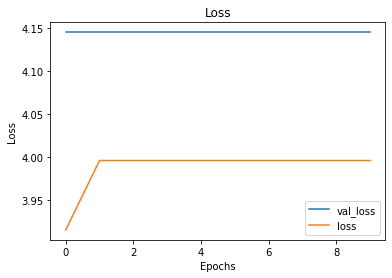

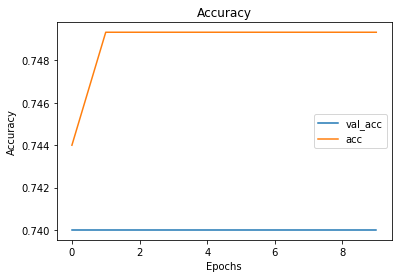

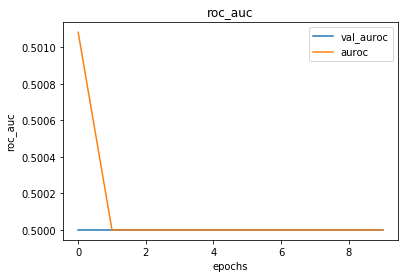

In [26]:
visualize_training_results(results_1)

Due to computational restraints, we need to keep epochs quite low. However, roc_score seems to be converging around 92%.Erratic values showcase how some of these results are still determined by chance. 

##  Adding another hidden layer

In [27]:
# instatiating a sequential model

model_2 = Sequential()
model_2.add(Dense(20, activation = 'relu', input_shape = (250000,)))
# added another hidden layer with 15 nodes and activation 'tanh'
model_2.add(Dense(15, activation = 'tanh'))

model_2.add(Dense(1, activation = 'sigmoid'))

In [28]:
# compiling the model
model_2.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy', auroc])

In [29]:
# fitting the model
results_2 = model_2.fit(train_img_dense,train_labels_final,
           epochs = 10,
           batch_size = 32,
           validation_data=(validation_img_dense,validation_labels_final)
           )

Train on 1500 samples, validate on 300 samples
Epoch 1/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.5715 - acc: 0.7400 - auroc: 0.6188 - val_loss: 0.5694 - val_acc: 0.7400 - val_auroc: 0.8951
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5507 - acc: 0.7493 - auroc: 0.9237 - val_loss: 0.5555 - val_acc: 0.7400 - val_auroc: 0.9075
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5524 - acc: 0.7387 - auroc: 0.9264 - val_loss: 0.5462 - val_acc: 0.7400 - val_auroc: 0.9099
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5252 - acc: 0.7493 - auroc: 0.9378 - val_loss: 0.5726 - val_acc: 0.7400 - val_auroc: 0.8119
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5450 - acc: 0.7553 - auroc: 0.9510 - val_loss: 0.5445 - val_acc: 0.7400 - val_auroc: 0.9202
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5691 - acc: 0.7493 - auro

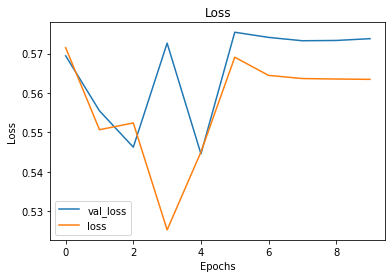

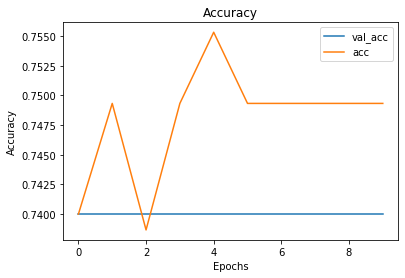

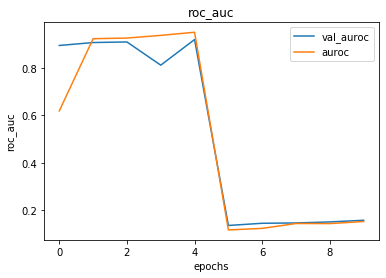

In [30]:
visualize_training_results(results_2)

We have introduced another layer but in this case, performance significantly decrease and we also found a local minima as our accurac got stuck at 75%.

##  Increasing the number of epochs to 25

In [31]:
# instatiating a sequential model

model_3 = Sequential()
model_3.add(Dense(20, activation = 'relu', input_shape = (250000,)))

model_3.add(Dense(1, activation = 'sigmoid'))

In [32]:
# compiling the model
model_3.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy', auroc])

In [33]:
# fitting the model
results_3 = model_3.fit(train_img_dense,train_labels_final,
           epochs = 25,
           batch_size = 32,
           validation_data=(validation_img_dense,validation_labels_final)
           )

Train on 1500 samples, validate on 300 samples
Epoch 1/25
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9461 - acc: 0.7373 - auroc: 0.5041 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 2/25
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 3/25
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 4/25
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 5/25
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 6/25
1500/1500 [==============================] - 2s 1ms/step - loss: 3.9962 - acc: 0.7493 - auro

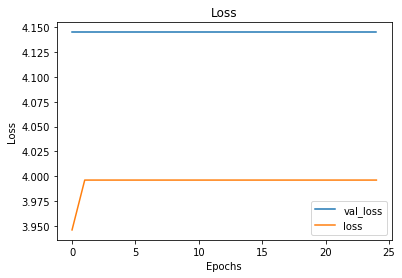

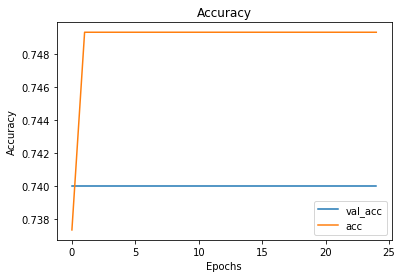

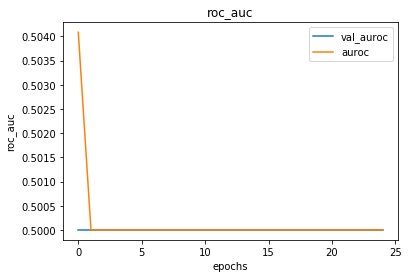

In [34]:
visualize_training_results(results_3)

Increasing the epochs reveals a clearer pattern around...

##  Changing optimiser to Adam

In [35]:
# instatiating a sequential model

model_4 = Sequential()
model_4.add(Dense(20, activation = 'relu', input_shape = (250000,)))

model_4.add(Dense(1, activation = 'sigmoid'))

In [36]:
# compiling the model
model_4.compile(loss='binary_crossentropy', 
                optimizer='adam', # changed the optimizer here
                metrics=['accuracy', auroc])

In [37]:
# fitting the model
results_4 = model_4.fit(train_img_dense,train_labels_final,
           epochs = 10,
           batch_size = 32,
           validation_data=(validation_img_dense,validation_labels_final)
           )

Train on 1500 samples, validate on 300 samples
Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 3.9258 - acc: 0.7473 - auroc: 0.4991 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 6/10
 864/1500 [================>.............] - ETA: 1s - loss: 4.1148 - acc: 0.7419 - auroc: 0

InvalidArgumentError: ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.
	 [[Node: metrics_5/auroc/PyFunc = PyFunc[Tin=[DT_FLOAT, DT_FLOAT], Tout=[DT_DOUBLE], token="pyfunc_4", _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_dense_13_target_0_2, dense_13/Sigmoid)]]

Caused by op 'metrics_5/auroc/PyFunc', defined at:
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-ee7f2d277cd4>", line 4, in <module>
    metrics=['accuracy', auroc])
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/engine/training.py", line 451, in compile
    handle_metrics(output_metrics)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/engine/training.py", line 420, in handle_metrics
    mask=masks[i])
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/engine/training_utils.py", line 404, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-25-99008b89fd92>", line 3, in auroc
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 317, in py_func
    func=func, inp=inp, Tout=Tout, stateful=stateful, eager=False, name=name)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 225, in _internal_py_func
    input=inp, token=token, Tout=Tout, name=name)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/gen_script_ops.py", line 93, in _py_func
    "PyFunc", input=input, token=token, Tout=Tout, name=name)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/Users/marwankalo/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.
	 [[Node: metrics_5/auroc/PyFunc = PyFunc[Tin=[DT_FLOAT, DT_FLOAT], Tout=[DT_DOUBLE], token="pyfunc_4", _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_dense_13_target_0_2, dense_13/Sigmoid)]]


In [ ]:
visualize_training_results(results_4)

No significant difference found by changing the loss function. We'll keep using sgd for now.

##  Doubling the number of nodes

In [ ]:
# instatiating a sequential model

model_5 = Sequential()
# doubled the number of nodes here
model_5.add(Dense(40, activation = 'relu', input_shape = (250000,)))

model_5.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# compiling the model
model_5.compile(loss='binary_crossentropy', 
                optimizer='sgd',
                metrics=['accuracy', auroc])

In [ ]:
# fitting the model
results_5 = model_5.fit(train_img_dense,train_labels_final,
           epochs = 10,
           batch_size = 32,
           validation_data=(validation_img_dense,validation_labels_final)
           )

In [ ]:
visualize_training_results(results_5)

Increasing the number of nodes seem to have had the biggets impact on performance out of all the tweaking on the initial baseline. We'll keep that in mind and start of our CNN modelling with at least 40 nodes. Also, teh final divergence between validation and training in the loss function might be an indicator of training starting to overfit.

# Convolutional Neural Network

For CNN we are taking a different input in terms of image size compared to the previous one we used in Dense. In this case we will pass the full tensor as a 500x500x1. Re-size and image pre-processing has been applied already at the beginning of the notebook.

In [ ]:
# looking again at the dataset shapes of all our images

print('------------data')
print(train_images.shape)
print(validation_images.shape)
print(test_images.shape)


print('-----------target')
print(train_labels.shape)
print(validation_labels.shape)
print(test_labels.shape)


## Model 1 with one Convolutional Layer and one Pool

As mentioned, CNNs do a much better job at dealing with image classification problems. Our first iteration is made of a 2d covoloutional layer with as many nodes as the best performing baseline model (40) and also a maxpool 2d layer. We still have a final Dense layer with one node and sigmoid given the binary nature of the classification.

In [38]:
# Intitialise your NN
model_cnn = Sequential()
# Add a convolutional layer
model_cnn.add(Conv2D(40,kernel_size=(3,3),strides=1,input_shape=(500,500,1),activation='relu'))
# Add a pooling layer
model_cnn.add(MaxPool2D(pool_size=(1,1),strides=2))
# Add a flattening layer
model_cnn.add(Flatten())
# Add a dense layer suitable for a binary classification
model_cnn.add(Dense(1,activation='sigmoid'))
# Compile your CNN
model_cnn.compile(optimizer='sgd',metrics=['accuracy', auroc],loss='binary_crossentropy')
# Show summary and compare with your partner
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 498, 40)      400       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 249, 40)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2480040)           0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2480041   
Total params: 2,480,441
Trainable params: 2,480,441
Non-trainable params: 0
_________________________________________________________________


In [39]:
results_cnn_1 = model_cnn.fit(train_images,train_labels_final,
                    epochs=10,
                    batch_size = 32,
                    validation_data=(validation_images,validation_labels_final),
                    
                    )

Train on 1500 samples, validate on 300 samples
Epoch 1/10
1500/1500 [==============================] - 156s 104ms/step - loss: 3.9149 - acc: 0.7493 - auroc: 0.4955 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 2/10
1500/1500 [==============================] - 157s 105ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 3/10
1500/1500 [==============================] - 152s 101ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 4/10
1500/1500 [==============================] - 159s 106ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 5/10
1500/1500 [==============================] - 151s 101ms/step - loss: 3.9962 - acc: 0.7493 - auroc: 0.5000 - val_loss: 4.1450 - val_acc: 0.7400 - val_auroc: 0.5000
Epoch 6/10
1500/1500 [==============================] - 147s 98ms/step - loss: 3.99

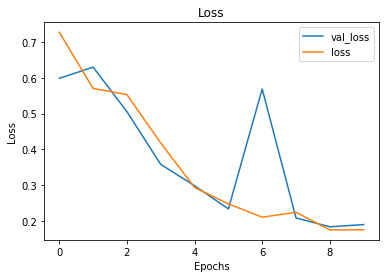

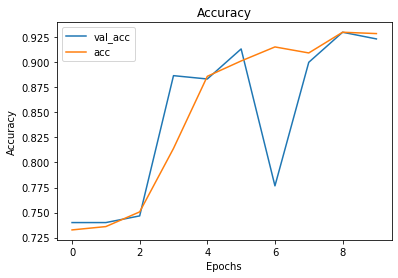

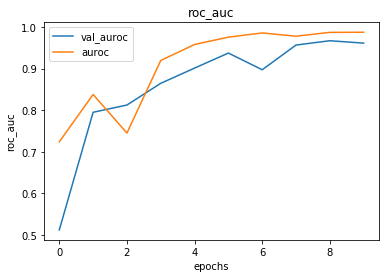

In [100]:
visualize_training_results(results_cnn_1 )

Overall initial results seem to be performing better than our best results with baseline.
There's no clear signs of convergence which we can address by also adding more epochs. Another convolutional layer will be also added in the second iteration.

## Model 2 with 2 Convolutional Layers, 2 Pool layers and increasing epochs to 25

In [101]:
# Intitialise your NN
model_cnn_2 = Sequential()
# Add a convolutional layer
model_cnn_2.add(Conv2D(40,kernel_size=(3,3),strides=1,input_shape=(500,500,1),activation='relu'))
# Add a pooling layer
model_cnn_2.add(MaxPool2D(pool_size=(2,2),strides=2))
# Add a SECOND convolutional layer
model_cnn_2.add(Conv2D(20,kernel_size=(3,3),strides=1,activation='relu'))
# Add a SECOND pooling layer
model_cnn_2.add(MaxPool2D(pool_size=(2,2),strides=2))
# Add a flattening layer
model_cnn_2.add(Flatten())
# Add a dense layer suitable for a binary classification
model_cnn_2.add(Dense(1,activation='sigmoid'))
# Compile your CNN
model_cnn_2.compile(optimizer='sgd',metrics=['accuracy', auroc],loss='binary_crossentropy')
# Show summary 
model_cnn_2.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 498, 498, 40)      400       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 249, 249, 40)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 247, 247, 20)      7220      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 123, 123, 20)      0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 302580)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 302581    
Total params: 310,201
Trainable params: 310,201
Non-trainable params: 0
_______________________________________________

In [102]:
results_cnn_2 = model_cnn_2.fit(train_images,train_labels_final,
                    epochs=25,
                    batch_size = 32,
                    validation_data=(validation_images,validation_labels_final),
                     )

Train on 1500 samples, validate on 300 samples
Epoch 1/25
1500/1500 [==============================] - 308s 205ms/step - loss: 0.5473 - accuracy: 0.7467 - auroc: 0.8178 - val_loss: 0.4477 - val_accuracy: 0.8967 - val_auroc: 0.8787
Epoch 2/25
1500/1500 [==============================] - 305s 203ms/step - loss: 0.5346 - accuracy: 0.7667 - auroc: 0.8920 - val_loss: 0.4563 - val_accuracy: 0.7667 - val_auroc: 0.8848
Epoch 3/25
1500/1500 [==============================] - 309s 206ms/step - loss: 0.4243 - accuracy: 0.8060 - auroc: 0.9506 - val_loss: 0.3609 - val_accuracy: 0.8800 - val_auroc: 0.9368
Epoch 4/25
1500/1500 [==============================] - 304s 202ms/step - loss: 0.2722 - accuracy: 0.8913 - auroc: 0.9736 - val_loss: 0.2817 - val_accuracy: 0.8867 - val_auroc: 0.9416
Epoch 5/25
1500/1500 [==============================] - 312s 208ms/step - loss: 0.2498 - accuracy: 0.9067 - auroc: 0.9784 - val_loss: 0.3453 - val_accuracy: 0.8633 - val_auroc: 0.9574
Epoch 6/25
1500/1500 [===========

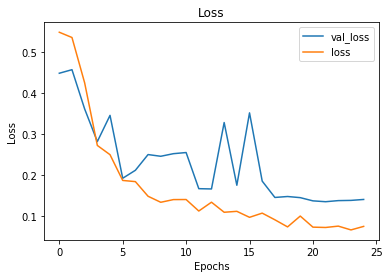

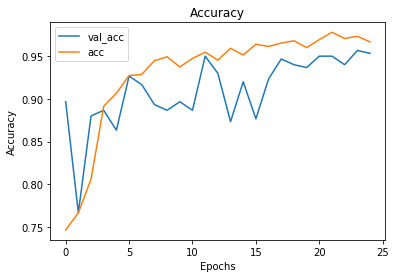

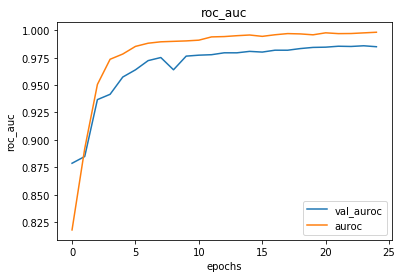

In [103]:
visualize_training_results(results_cnn_2)

Performance on roc_score is relatively strong and we can see some initial signs of convergence.
However, the validation loss function is still too erratic. We'll increase number of images both for the training and validation model to try get better results. In order to mitigate overfitting we'll also apply some layer dropouts in the model.


## Increasing number of images analysed, epochs to 15, nodes and dropouts applied

In [83]:
# selecting another set of images
train_generator_final_cnn = ImageDataGenerator(rescale= 1./255).flow_from_directory(
        train_directory, 
        target_size=(500,500),
        batch_size = 4000,
        color_mode = 'grayscale',
        seed = 2002
        )

validation_generator_base_final_cnn = ImageDataGenerator(rescale= 1./255).flow_from_directory(
        validation_directory, 
        target_size=(500,500),
        batch_size = 1000,
        color_mode= 'grayscale',
        seed= 29
        )

train_images_final_cnn, train_labels_cnn = next(train_generator_final_cnn)
validation_images_final_cnn, validation_labels_cnn = next(validation_generator_base_final_cnn)

Found 4201 images belonging to 2 classes.
Found 1028 images belonging to 2 classes.


In [84]:
# reshaping the final cnn train and test labels with 1 corresponding to positive to pneumonia

train_labels_final_cnn = train_labels_cnn.T[[1]].T
validation_labels_final_cnn = validation_labels_cnn.T[[1]].T


In [85]:
# printing shapes
print(train_labels_final_cnn.shape)
print(validation_labels_final_cnn.shape)


(4000, 1)
(1000, 1)


In [87]:
# double-checking what tuple corresponds to each class 

print(train_generator_final_cnn .class_indices)
print(validation_generator_base_final_cnn.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [88]:
# Intitialise your NN
model_cnn_3 = Sequential()
# Add a droput layer with initial inout
model_cnn_3.add(Dropout(0.2, input_shape=(500,500,1)))
# Add a convolutional layer
model_cnn_3.add(Conv2D(50,kernel_size=(3,3),strides=1,activation='relu'))
# Add a pooling layer
model_cnn_3.add(MaxPool2D(pool_size=(2,2),strides=2))
# droput added
model_cnn_3.add(Dropout(0.2))
# Add a SECOND convolutional layer
model_cnn_3.add(Conv2D(25,kernel_size=(3,3),strides=1,activation='relu'))
# Add a SECOND pooling layer
model_cnn_3.add(MaxPool2D(pool_size=(2,2),strides=2))
# add a dropout
model_cnn_3.add(Dropout(0.2))
# Add a flattening layer
model_cnn_3.add(Flatten())
# Add a dense layer suitable for a binary classification
model_cnn_3.add(Dense(1,activation='sigmoid'))
# Compile your CNN
model_cnn_3.compile(optimizer='sgd',metrics=['accuracy', auroc],loss='binary_crossentropy')
# Show summary 
model_cnn_3.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_13 (Dropout)         (None, 500, 500, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 498, 498, 50)      500       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 249, 249, 50)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 249, 249, 50)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 247, 247, 25)      11275     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 123, 123, 25)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 123, 123, 25)     

In [89]:
results_cnn_3 = model_cnn_3.fit(train_images_final_cnn,train_labels_final_cnn,
                    epochs=15,
                    batch_size = 32,
                    validation_data=(validation_images_final_cnn,validation_labels_final_cnn),
                    class_weight = 'balanced')
                    

Train on 4000 samples, validate on 1000 samples
Epoch 1/15
4000/4000 [==============================] - 2044s 511ms/step - loss: 0.5642 - accuracy: 0.7585 - auroc: 0.8383 - val_loss: 0.6638 - val_accuracy: 0.8250 - val_auroc: 0.9558
Epoch 2/15
4000/4000 [==============================] - 1623s 406ms/step - loss: 0.2863 - accuracy: 0.8788 - auroc: 0.9694 - val_loss: 0.4068 - val_accuracy: 0.8420 - val_auroc: 0.9643
Epoch 3/15
4000/4000 [==============================] - 1493s 373ms/step - loss: 0.1758 - accuracy: 0.9315 - auroc: 0.9847 - val_loss: 0.3186 - val_accuracy: 0.9160 - val_auroc: 0.9701
Epoch 4/15
4000/4000 [==============================] - 2622s 655ms/step - loss: 0.1549 - accuracy: 0.9430 - auroc: 0.9878 - val_loss: 0.2981 - val_accuracy: 0.8920 - val_auroc: 0.9722
Epoch 5/15
4000/4000 [==============================] - 1414s 354ms/step - loss: 0.1325 - accuracy: 0.9498 - auroc: 0.9894 - val_loss: 0.3432 - val_accuracy: 0.8500 - val_auroc: 0.9590
Epoch 6/15
4000/4000 [=====

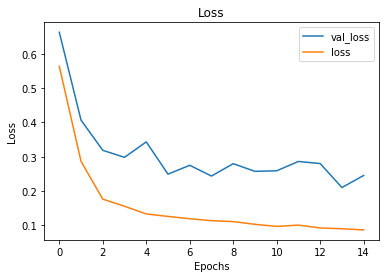

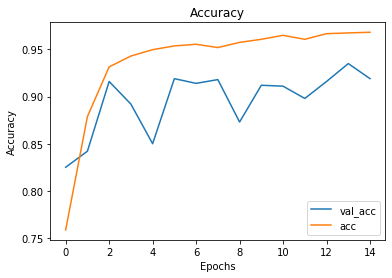

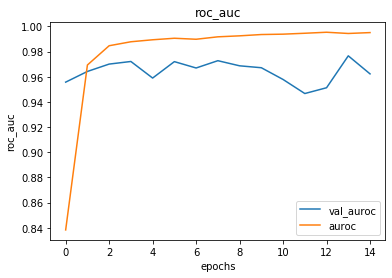

In [93]:
visualize_training_results(results_cnn_3)

It seems like we are getting the best convergence and performance with **CNN number 2** before applying the droput and on a smaller dataset both for training and validation. One possible explanation could be that the last model was picking on parameters that are not really important, creating an overall worse model.

# Evaluating performance of winning model on the training/test

In [108]:
# evaluating performance on the entire training dataset 4000 images
perf_training = model_cnn_2.evaluate(train_images,train_labels_final)

print(perf_training)
perf_test = model_cnn_2.evaluate(test_images, test_labels_final)
perf_test

1500/1500 [==============================] - 75s 50ms/step
[0.05999642173449198, 0.9733333587646484, 0.9990194439888]
600/600 [==============================] - 28s 47ms/step


[1.2270861593882243, 0.7149999737739563, 0.8815715909004211]

# Cost Evaluation for pneumonia cases

Our x-rays were collected from a number of hospitals in the Guangzhou area in mainland China. As a consequence, we'll take some figures that are relevant to that area in order to come up with a meaningful prevalence. Prevalence is defined as the number of occurences of a specific event over the total population.

According to the article below, there are approximately 2,500,000 cases of pneumonia per year in China.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2909231/

Prevalence would be given by: Pneumonia Cases / Total Population

**Prevalence percentage** is then equal to 2,500,0000 / 1,000,000,000 = 0.0025

Also, below we have come up with possible estimates on the potential costs behind each predictions of our model based on US hospital costs associated with patients of pneumonia. Assuming that China has similar costs since we couldn't find Chinese specific costs. Link below:

https://www.ncbi.nlm.nih.gov/pubmed/30217156

TN = $0

This would be the instance in which the model correctly identify an healthy patient. 
Virtually no cost associated to it apart from the x-ray which we will ignore in this case.


FN = $10,800

This would when our model wrongly believes that the patient is not affected by pneumonia. If untreated it leads to hospitalisation and eventually death. It is the costlier of our outcomes. Hospitalisation is on average around $10,800 per patient.

FP = $424

Model mistakenly think we have pneumonia when we actually don't. Cost associated to a doctor visit and medical supplies.

TP = $424

Model is correct in its prediction and go for further visit with doctors and drugs.



**Metz Parameter is given by:**
    

    


In [123]:
Prevalence = 0.0025
FP = 424
TP = 424
TN = 0
FN = 10800

m = ((1.0 - Prevalence)/(Prevalence)) * ((424-0)/(10800-424))

print(f'The metz parameter is {m}')

The metz parameter is 16.30454895913647


# Plotting the Roc Curve for Winning Model

In [116]:
# calculating fpr,tpr and threshold for both training and test for winning model
y_hat_model_2_cnn_train = model_cnn_2.predict_proba(train_images)
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels_final, y_hat_model_2_cnn_train)

y_hat_model_2_cnn_test = model_cnn_2.predict_proba(test_images)
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels_final, y_hat_model_2_cnn_test)

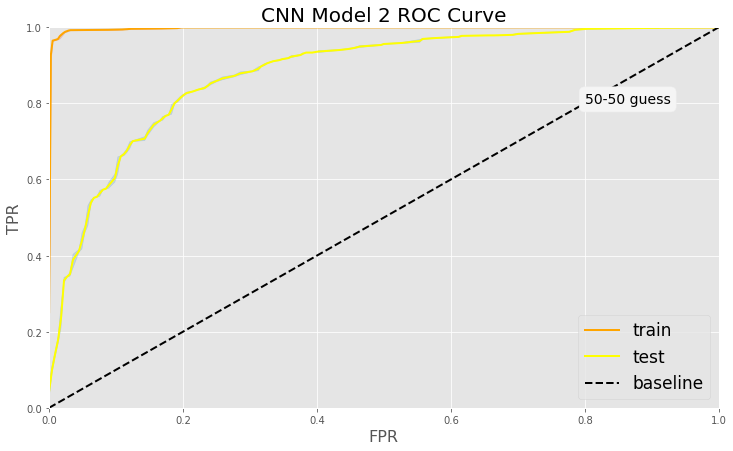

In [119]:
plt.style.use('ggplot')
plt.figure(figsize=(12,7))
ax1 = sns.lineplot(fpr_train, tpr_train, label='train',)
ax1.lines[0].set_color("orange")
ax1.lines[0].set_linewidth(2)

ax2 = sns.lineplot(fpr_test, tpr_test, label='test')
ax2.lines[1].set_color("yellow")
ax2.lines[1].set_linewidth(2)

ax3 = sns.lineplot([0,1], [0,1], label='baseline')
ax3.lines[2].set_linestyle("--")
ax3.lines[2].set_color("black")
ax3.lines[2].set_linewidth(2)

plt.title('CNN Model 2 ROC Curve', fontsize=20)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.text(x=0.8, y=0.8, s="50-50 guess", fontsize=14,
         bbox=dict(facecolor='whitesmoke', boxstyle="round, pad=0.4"))

plt.legend(loc=4, fontsize=17)
plt.show();

**Calculating the ideal threshold based on the fm parameter**

In [121]:
# calculating the fm list 
fm_list = (tpr_test) -(metz*(fpr_test))
list(zip(fm_list.tolist(), thresholds_test.tolist()))

[(0.0, 2.0),
 (0.007978723404255319, 1.0),
 (0.02925531914893617, 0.9999998807907104),
 (0.03723404255319149, 0.9999997615814209),
 (0.047872340425531915, 0.9999996423721313),
 (0.06382978723404255, 0.9999991655349731),
 (0.07446808510638298, 0.9999990463256836),
 (0.0797872340425532, 0.9999983310699463),
 (0.009658643514493345, 0.9999982118606567),
 (0.017637366918748676, 0.9999980926513672),
 (0.020296941386833772, 0.9999979734420776),
 (0.025616090323003993, 0.9999978542327881),
 (0.044233111599599736, 0.9999966621398926),
 (0.04955226053576994, 0.9999960660934448),
 (-0.023235904460375004, 0.9999959468841553),
 (-0.012597606588034577, 0.9999953508377075),
 (-0.007278457651864356, 0.999995231628418),
 (-0.0019593087156941358, 0.9999948740005493),
 (0.003359840220476057, 0.9999946355819702),
 (0.011338563624731374, 0.9999940395355225),
 (-0.06144960137141356, 0.9999938011169434),
 (-0.05081130349907312, 0.999992847442627),
 (-0.040173005626732705, 0.9999924898147583),
 (-0.0348538566

Picking 60 as the threshold

In [128]:
# creating a new list with threshold 0.53 separating churn 1 and non-churn 0
probs_list_test = model_cnn_2.predict_proba(test_images)

final_positive =[]
for x in probs_list_test:
    if x > 0.35:
        final_positive.append(1)
    else:
        final_positive.append(0)
final_res
len(final_positive)

600

In [131]:
# plotting the confusion matrix for the .60 threshold
confusion_matrix(test_labels_final, final_positive)

array([[ 49, 175],
       [  3, 373]])

In [132]:

# evaluating performance on this specific confusion matrix
accuracy = print('Accuracy Score', accuracy_score(test_labels_final, final_positive))
roc_score = print('ROC_score ', roc_auc_score(test_labels_final, y_hat_model_2_cnn_test))
precision = print('Precision ', precision_score(test_labels_final, final_positive))
recall= print('Recall or TPR ', recall_score(test_labels_final, final_positive))
f1__score = print('F1 score ', f1_score(test_labels_final, final_positive))


Accuracy Score 0.7033333333333334
ROC_score  0.8794820953647415
Precision  0.6806569343065694
Recall or TPR  0.9920212765957447
F1 score  0.8073593073593074


# Second stage - Original Dataset

Now we will restart the process using the orinal set of data provided to us and compare results, choosing the best outcome

In [5]:
path = '../imageclassification_pneumonia_deeplearning/chest_xray/chest_xray'

train_folder = path + '/train/'
test_folder  = path + '/test/'
val_folder   = path + '/val/'

train_normal = train_folder + 'NORMAL/'
train_pneumonia   = train_folder + 'PNEUMONIA/'
# We can then take our training folder and and set the paths to each class. In this case, we have two classes: The normal images and the pneumonia images. If we want to visualize images that are specifically "normal" or "pneumonia", then we will create a variable that contains the path to these images for later reference.

pneumonia_images   = glob(train_pneumonia + "*.jpeg")
normal_images = glob(train_normal + "*.jpeg")
# Now that we have split the training folder into "normal" and "pneumonia", we can pull all of the images out of each class. The images in this dataset are all jpeg images, so for each path we will add .jpeg at the end to make sure we are pulling out the images. The reason for this is because we want to get a visual of our data.

def show_imgs(num_of_imgs):
    
    for img in range(num_of_imgs):
        pneu_pic   = np.asarray(plt.imread(pneumonia_images[img]))
        normal_pic = np.asarray(plt.imread(normal_images[img]))

        fig = plt.figure(figsize= (15,15))

        normal_plot = fig.add_subplot(1,2,1)
        plt.imshow(normal_pic, cmap='gray')
        normal_plot.set_title('Normal')
        plt.axis('off')

        pneu_plot = fig.add_subplot(1, 2, 2)
        plt.imshow(pneu_pic, cmap='gray')
        pneu_plot.set_title('Pneumonia')
        plt.axis('off')
    
        plt.show()

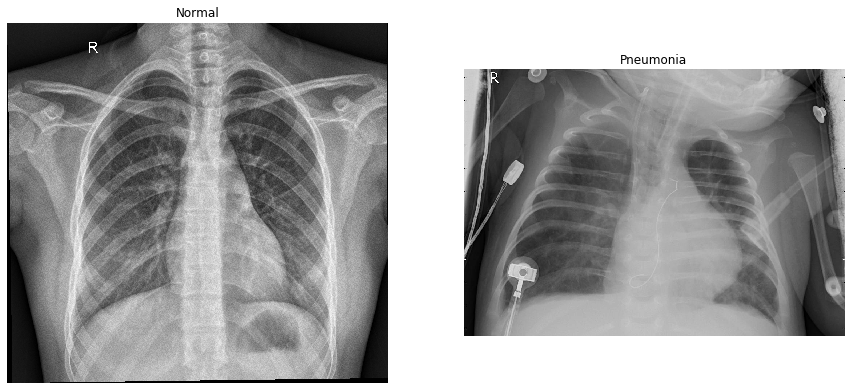

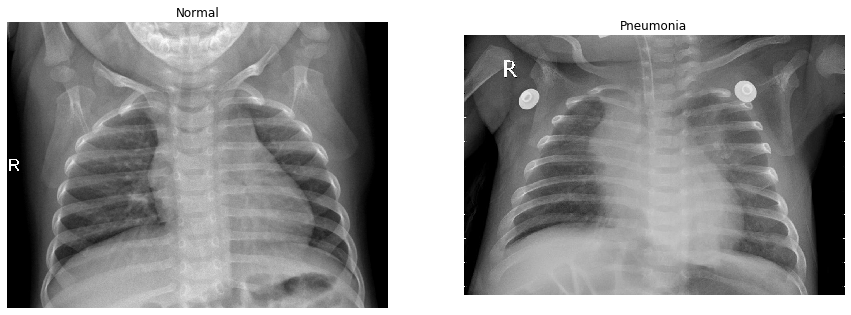

In [6]:
show_imgs(2)

In [7]:
print('Number of pneumonia training images:', len(pneumonia_images))
print('Number of normal training images:', len(normal_images))

Number of pneumonia training images: 3875
Number of normal training images: 1341


In [8]:
from keras.preprocessing.image import ImageDataGenerator

Here we set up the different sets of data, scale them, convert to grayscale, change size and assign a batch_size

In [9]:
train_v_datagen = ImageDataGenerator(
        rescale=1./255)
val_datagen = ImageDataGenerator(
        rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_v_datagen.flow_from_directory(
        train_folder,
        target_size=(200, 200),
        batch_size=32,
        class_mode='binary',
        color_mode='grayscale',
        seed=123)

Found 5216 images belonging to 2 classes.


In [11]:
validation_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(200, 200),
        batch_size=32,
        class_mode='binary',
        color_mode='grayscale',
        seed=123)

Found 16 images belonging to 2 classes.


In [12]:
test_set = test_datagen.flow_from_directory(test_folder,
        target_size= (200, 200),
        batch_size = 32,
        class_mode = 'binary',
        color_mode='grayscale',
        seed=123)

Found 624 images belonging to 2 classes.


## CNN - 1st Iteration

In [54]:
model1 = Sequential()
model1.add(Conv2D(64, (3, 3), input_shape=(200,200,1)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 64)      640       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 97, 97, 32)        18464     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 97, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 64)        18496     
__________

In [55]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', auroc])

In [56]:
model1.fit_generator(train_generator, 
                    steps_per_epoch = 6,
                    epochs = 10, 
                    validation_data = validation_generator,
                    class_weight=[0.4,0.6])

Epoch 1/10
6/6 [==============================] - 9s 1s/step - loss: 0.6472 - acc: 0.7135 - auroc: 0.5801 - val_loss: 0.7879 - val_acc: 0.5000 - val_auroc: 0.5312
Epoch 2/10
6/6 [==============================] - 9s 1s/step - loss: 0.5695 - acc: 0.7552 - auroc: 0.5379 - val_loss: 0.8116 - val_acc: 0.5000 - val_auroc: 0.5781
Epoch 3/10
6/6 [==============================] - 9s 1s/step - loss: 0.5135 - acc: 0.7708 - auroc: 0.7164 - val_loss: 0.8806 - val_acc: 0.5000 - val_auroc: 0.6875
Epoch 4/10
6/6 [==============================] - 8s 1s/step - loss: 0.4749 - acc: 0.7865 - auroc: 0.8386 - val_loss: 0.6644 - val_acc: 0.5000 - val_auroc: 0.8281
Epoch 5/10
6/6 [==============================] - 9s 1s/step - loss: 0.4158 - acc: 0.7708 - auroc: 0.9742 - val_loss: 0.8257 - val_acc: 0.6250 - val_auroc: 0.7969
Epoch 6/10
6/6 [==============================] - 9s 1s/step - loss: 0.3575 - acc: 0.8438 - auroc: 0.9372 - val_loss: 0.8977 - val_acc: 0.6250 - val_auroc: 0.8281
Epoch 7/10
6/6 [======

A good performance in general - now to tune some parameters

## CNN - 2nd Iteration

During our second iteration we have increased the number of nodes on the first convolutional layer to 128 instead of 64 and increased dropout from 0.2 to 0.3 in an attempt to help our model generalise better.

In [65]:
model2 = Sequential()
model2.add(Conv2D(128, (3, 3), input_shape=(200,200,1)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 198, 198, 128)     1280      
_________________________________________________________________
activation_11 (Activation)   (None, 198, 198, 128)     0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 97, 97, 32)        36896     
_________________________________________________________________
activation_12 (Activation)   (None, 97, 97, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 46, 64)        18496     
__________

For the second iteration, we have changed the optimizer to stochastic gradient descent and tuned the learning_rate as well as set a momentum of 0.8

In [62]:
learning_rate = 0.1 
decay_rate = 0.1
momentum = 0.8

# define the optimizer function
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [63]:
model2.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy', auroc])

In [64]:
model2.fit_generator(train_generator, 
                    steps_per_epoch = 6,
                    epochs = 8, 
                    validation_data = validation_generator)

Epoch 1/8
6/6 [==============================] - 19s 3s/step - loss: 0.5619 - acc: 0.7552 - auroc: 0.5122 - val_loss: 1.0941 - val_acc: 0.5000 - val_auroc: 0.4844
Epoch 2/8
6/6 [==============================] - 18s 3s/step - loss: 0.5687 - acc: 0.7656 - auroc: 0.4970 - val_loss: 0.7232 - val_acc: 0.5000 - val_auroc: 0.6250
Epoch 3/8
6/6 [==============================] - 18s 3s/step - loss: 0.5674 - acc: 0.7708 - auroc: 0.5257 - val_loss: 0.7923 - val_acc: 0.5000 - val_auroc: 0.5156
Epoch 4/8
6/6 [==============================] - 19s 3s/step - loss: 0.5774 - acc: 0.7708 - auroc: 0.4693 - val_loss: 0.8313 - val_acc: 0.5000 - val_auroc: 0.5156
Epoch 5/8
6/6 [==============================] - 19s 3s/step - loss: 0.5888 - acc: 0.7344 - auroc: 0.5381 - val_loss: 0.7942 - val_acc: 0.5000 - val_auroc: 0.6406
Epoch 6/8
6/6 [==============================] - 17s 3s/step - loss: 0.5979 - acc: 0.7135 - auroc: 0.5286 - val_loss: 0.7582 - val_acc: 0.5000 - val_auroc: 0.7031
Epoch 7/8
6/6 [=======

This iteration did not improve our validation performance therefore we shall tune different parameters in the next iteration

## CNN - 3rd Iteration

For the third iteration, we have doubled the number of nodes at the first and second convolutional layers. Also we have added an extra dropout layer after the second convolutional layer and increased the dropout after the penultimate dense layer by 0.1.

In [14]:
model3 = Sequential()
model3.add(Conv2D(256, (3, 3), input_shape=(200,200,1)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3)))
model3.add(Dropout(0.3))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(64))
model3.add(Activation('relu'))
model3.add(Dropout(0.4))
model3.add(Dense(1))
model3.add(Activation('sigmoid'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 198, 198, 256)     2560      
_________________________________________________________________
activation_2 (Activation)    (None, 198, 198, 256)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 64)        147520    
_________________________________________________________________
dropout_1 (Dropout)          (None, 97, 97, 64)        0         
_________________________________________________________________
activation_3 (Activation)    (None, 97, 97, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
__________

In [18]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', auroc])

We swtiched the optimizer back to adam which was giving us a strong score intitally and increased the steps per epoch to 10 as well as the number of epochs to 20

In [49]:
final_model = model3.fit_generator(train_generator, 
                    steps_per_epoch = 10,
                    epochs = 20, 
                    validation_data = validation_generator)

Epoch 1/20
10/10 [==============================] - 69s 7s/step - loss: 0.2291 - acc: 0.9125 - auroc: 0.9717 - val_loss: 0.3887 - val_acc: 0.8125 - val_auroc: 0.8281
Epoch 2/20
10/10 [==============================] - 67s 7s/step - loss: 0.2580 - acc: 0.8906 - auroc: 0.9530 - val_loss: 0.4885 - val_acc: 0.6250 - val_auroc: 0.8906
Epoch 3/20
10/10 [==============================] - 67s 7s/step - loss: 0.1849 - acc: 0.9375 - auroc: 0.9770 - val_loss: 0.4061 - val_acc: 0.6875 - val_auroc: 0.9688
Epoch 4/20
10/10 [==============================] - 71s 7s/step - loss: 0.1663 - acc: 0.9219 - auroc: 0.9833 - val_loss: 0.3097 - val_acc: 0.8125 - val_auroc: 0.9375
Epoch 5/20
10/10 [==============================] - 70s 7s/step - loss: 0.1771 - acc: 0.9281 - auroc: 0.9769 - val_loss: 0.4507 - val_acc: 0.6875 - val_auroc: 0.9375
Epoch 6/20
10/10 [==============================] - 67s 7s/step - loss: 0.1436 - acc: 0.9531 - auroc: 0.9847 - val_loss: 0.3709 - val_acc: 0.8750 - val_auroc: 0.9531
Epoc

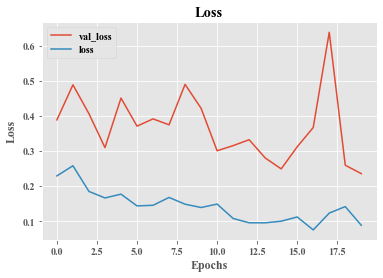

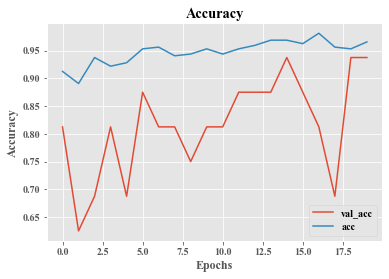

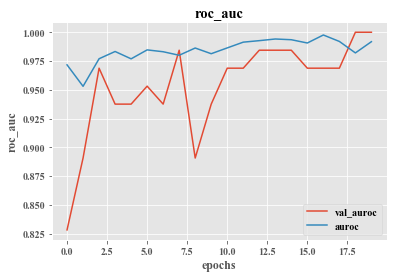

In [50]:
visualize_training_results(final_model)

This us our best performing model in this new section using the originally subset data, let us see how it performs on our test data!

## Winning model evaluation

In [20]:
scores = model3.evaluate_generator(test_set)
print("\n%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))
print("\n%s: %.2f%%" % (model3.metrics_names[2], scores[2]*100))


acc: 74.84%

auroc: 92.40%


The accuracy and area under the roc curve on our test set in this model exceeds that of our model in the first section! It generalises better and that is likely owing to the two dropout layers.

Time to assign a threshold and check the key metrics

In [ ]:
y_pred = probabilities > 0.5
y_pred_train = probabilities_train > 0.5

In [45]:
# Once again we remind ourselves of our prevalence and cost and cost of each outcome
Prevalence = 0.0025
FP = 424
TP = 424
TN = 0
FN = 10800

m = ((1.0 - Prevalence)/(Prevalence)) * ((424-0)/(10800-424))

print(f'The metz parameter is {m}')

The metz parameter is 16.30454895913647


In [ ]:
y_true = test_set.classes
y_true_train = train_generator.classes
fpr_train, tpr_train, thresholds_train = roc_curve(y_true_train, probabilities_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_true, probabilities)

In [ ]:
filenames_test = test_set.filenames
nb_samples_test = len(filenames_test)

filenames = train_generator.filenames
nb_samples = len(filenames)

probabilities = model3.predict_generator(generator=test_set,steps = nb_samples_test)
probabilities_train = model3.predict_generator(generator=train_generator, steps=nb_samples)

In [28]:
fm_list = tpr_test-(m*fpr_test)
list(zip(fm_list.tolist(), thresholds_test.tolist()))

[(0.0, 1.9999911785125732),
 (0.002564102564102564, 0.9999911785125732),
 (-0.13679101674475616, 0.9999618530273438),
 (-0.12909870905244847, 0.9999338388442993),
 (-0.26845382836130716, 0.999908447265625),
 (-0.26332562323310205, 0.9998849630355835),
 (-0.33043908032342884, 0.9998774528503418),
 (-0.3253108751952237, 0.9998617172241211),
 (-0.4646659945040824, 0.9998420476913452),
 (-0.45953778937587725, 0.9997918009757996),
 (-0.598892908684736, 0.9997733235359192),
 (-0.5912006009924283, 0.999716579914093),
 (-0.730555720301287, 0.9997106194496155),
 (-0.7254275151730819, 0.9996629953384399),
 (-0.7951050748275112, 0.999660849571228),
 (-0.7694640491864856, 0.9995583891868591),
 (-0.8391416088409149, 0.9995489716529846),
 (-0.8365775062768124, 0.9995334148406982),
 (-0.9759326255856711, 0.9995146989822388),
 (-0.9477274973805428, 0.9993175268173218),
 (-1.0174050570349722, 0.9993153810501099),
 (-1.0097127493426645, 0.9991388320922852),
 (-1.2187454283059524, 0.9990898370742798),
 (

In [2]:
probs_list = probabilities

my_results =[]
for x in probs_list:
    if x>0.15437784790992737:
        my_results.append(1)
    else:
        my_results.append(0)
my_results

confusion = []
for i, real in enumerate(y_true.tolist()):
    if my_results[i] == real:
        if my_results[i] == 0:
            confusion.append("TN")
        else:
            confusion.append("TP")
    else:
        if my_results[i] == 0:
            confusion.append("FN")
        else:
            confusion.append("FP")
        
pd.Series(confusion).value_counts()

NameError: name 'probabilities' is not defined

Our final model confusion matrix looks like this! In the end we had better performance on our previous final model and we will use that.